# Week 2

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [5]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

# Estimates for the covariance matrix

**Modern Portfolio Theory (MPT)** was born with the efficient frontier analysis of **Markowitz** (1952). Unfortunately, early applications of the technique, based on naive estimates of the input parameters, have been found to be of little use because they often lead to non-sensible portfolio allocations.

We talked about the MPT a lot in the **notebook of week-2 of the first course**. We constructed the efficient frontiers using past data, and we could see what was the optimal weight allocation when constructing a portfolio of $N$ stocks. 

Of course, such optimal allocation was based on **past** returns and covariances (and variances). However, if we are going to build the portfolio now, we do not know a priori what the efficient frontier looks like just because 
**we do not have future returns and covariances**. **These parameters have to be estimated!**

Here, we focus on bridging the gap between portfolio theory and portfolio construction by showing **how to generate enhanced parameter estimates** so as to improve the quality of the portfolio optimization outputs (optimal portfolio weights), with a focus on risk parameter estimates. 

We address **sample risk and explain how to improve covariance matrix estimation** via the use of factor and/or Bayesian techniques and statistical shrinkage estimators.

### Curse of dimensionality

Suppose we want to build a portfolio of $N$ stocks (of which we have available data). 
We then should **estimate**: 
- $N$ returns (expected returns), 
- $N$ volatilities, and 
- $N(N-1)/2$ covariances (correlation coefficients), as the covariance matrix contains $N$ entries, from which we remove the diagonal consisting of $N$ variances, and then, since it is symmetric, we divide by the remaining total number of entries). 

As $N$ grows, it may be a problem to have such a large number of parameters to estimate. For example, suppose we want to build a portfolio of $N=500$ stocks (as in the **S&P500**), then we have $N + N(N-1)/2 = N(N+1)/2 = 125,250$ entries to be estimated in the covariance matrix. 

In the presence of large portfolios, **the number of parameters if often larger than the sample size**, i.e., 
the length of the timeseries we have (daily, weekly, monthly). 
In order to get accurate estimates of the parameters we could in principle increase the sample size. 
However, **longer time series may increase modeling bias** and that is why the available sample size is usually in the order of hundreds or a few thousands. Hence, we rather have to end up with reducing the number of parameters.

### Parameter estimations

Recall that, given $N$ assets, we denote by $\Sigma$ be the $N\times N$ symmetric square 
covariance matrix, $\Sigma = [c_{ij}]$, 
where each element $c_{ij} := \rho_{ij} \sigma_i \sigma_j$ ($i,j=1,\dots,N$) 
denote the **covariance** between (the returns of) assets $i$ and asset $j$, 
with $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ being the volatility 
and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $c_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are the variances**). 
The volatility of the portfolio is then given 
by $\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }$.

#### No model risk - high sample risk

It is clear that the simplest **covariance estimator** is the **sample covariance matrix** 
$\Sigma = [c_{ij}]$. In this case, we have no model risk (we are just applying the definition) but we have a dependence on the sample size of the timeseries we are using. Also, we are going to estimate $N(N+1)/2$ parameters.

#### High model risk - low sample risk

A second estimator can be a simple **constant correlation model** in which we assume a constant correlation coefficient $rho$ for all assets. That is, we define the entries of our covariane matrix as 
$$
c_{ij} := \hat{\rho}\, \sigma_i \sigma_j.
\qquad i,j=1,\dots,N,
$$
This way, we avoid computing all different $\rho_{ij}$ (hence reducing the sample risk, since they 
rely on the timeseries that we are using) and we just need to estimate single volatilities, thus 
passing from a total $N(N+1)/2$ parameters to $N+1$. Obviuosly, we are introducing a risk model (we know that the correlation cannot be the same form every asset). The choice for this constant $\rho$ is the average of "true" correlations.
$$
\hat{\rho} := \frac{1}{N(N-1)} \sum_{i\neq j}^N \rho_{ij},
$$
Notice that in computing $\hat{\rho}$ we should compute all $\rho_{ij}$, hence where is the advantage? 
Here, the adavantage can be purely about reducing the sample risk rather than making computation faster as, for example, two assets can show a positive or a negative correlation when sampled at different frequencies. By using $\hat{\rho}$ we can get a more equilibrated correlation.

#### Using a factor model - (again, introducing model risk)

Recall (from week 1) that a simpe factor model is, for example, the Sharpe's **single-factor market model**:
$$
r_i^e := r_{i,t} - r_{f,t} = \beta^i (r_{m,t} - r_{f,t}) + \alpha_i + \varepsilon_{i,t}.
$$
for a given asset $i$ ($\varepsilon_{i,t}$ are the idiosyncratic uncorrelated errors).
In general, **multi-factor models** state that the excessive return of any asset $i$ 
over the risk-free rate satisfies:
$$
r_i^e = r_{i,t} - r_{f,t}  = \beta_1^i f_1 +\dots +\beta_K^i f_K + \varepsilon_{i,t}, 
$$
i.e., assume that asset's returns are driven by some factors. 

If a few factors can completely capture the cross-sectional risks, 
the number of parameters in covariance matrix estimation can be significantly reduced. 

An example using $2$ factors is the following. The model is given by:
$$
r_i^e := r_i - r_f =  \beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i
\quad \forall\;i=1,\dots,N.
$$
Now, the (squared) volatilities are given by, for all $i$: 
$$
c_{ii}^2 = \sigma_i^2 = \text{Var}\left(\beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i\right) 
= (\beta_1^i)^2 \sigma_{f_1}^2 + (\beta_2^i)^2 \sigma_{f_2}^2 + 2\beta_1^i \beta_2^i\text{Cov}(f_1,f_2) + \sigma_{\varepsilon_i}^2, 
$$
assuming that the covariances between the factor and the errors are zero. The covariances are then:
$$
c_{ij} = \text{Cov}\left(r_i^e,r_j^e\right) 
= \text{Cov}\left(\beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i, \beta_1^j f_1 + \beta_2^j f_2 + \varepsilon_j\right)
= \beta_1^i \beta_1^j \sigma_{f_1}^2 
+ \beta_2^i \beta_2^j \sigma_{f_2}^2 
+ \left(\beta_1^i \beta_2^j + \beta_2^i \beta_1^j\right) \text{Cov}(f_1,f_2) + \text{Cov}(\varepsilon_i,\varepsilon_j).
$$
Now, two things that we do is (i) try to look for uncorrelated factors so that $\text{Cov}(f_1,f_2)=0$ and 
(ii) **make the assumption that impose errors are uncorrelated** $\text{Cov}(\varepsilon_i,\varepsilon_j)=0$. 

Using a $2$ factor model, with condition (i) and (ii) satisfied, the total number of parameters to estimate in the covariance matrix are: $N$ coefficients $\beta_1$, 
$N$ coefficients $\beta_2$, and the $2$ volatilities of factors $\sigma_{f_1}$, $\sigma_{f_2}$, i.e., 
a total of $2(N+1)$ numbers.

Factors that could be used are:
- **explicit macro factors** such as inflation growth, interest rate$\dots$
- **explicit micro factors** such as characteristic of different stocks like country, size, B/P ratios$\dots$
- **implicit factors** when we only rely on data.

Using a factor model is a convenient way to **reduce the number of risk parameters** that have to be estimated. However, it introduces, of course, a reasonable amount of **model risk**.
Also, **implicit factor model** is usually preferred sice it lets the data tell us what the relevant factors are, thus alleviating the model risk.

#### Statistical Shrinkage
**Statistical Shrinkage** allow one to find the optimal trade-off between **sample risk** and **model risk**. 
In particular, we are not going to choose between either or another, but, in fact, we mix them. 

The idea is based on the **average of two covariance matrix estimates**, one with **high sample risk** and one with 
**high model risk**:
$$
E_{shrink} := \delta \hat{F} + (1-\delta)\hat{S}
$$
where $\hat{F}$ is the **factor-model based estimator** of the covariance matrix, $\hat{S}$ which is instead an estimator of the covariance matrix which is not factor-model based, and $\delta$ is the shrinkage factor (in $(0,1)$). 

**Example**: consider two stocks with sample volatility estimates at $20\%$ and $30\%$, respectively, 
and sample correlation of $0.75$. Furthe, assume that the average of the sample correlation estimates of all stocks in the universe is $0.5$. 
What is for these two stocks the **sample-based covariance estimate**, 
the **constant correlation covariance estimate** and 
the covariance estimate based on **statistical shrinkage with a shrinkage factor of $50\%$**?

The sample-based covariance estimate is by definition given by 
$\text{Cov}(r_1,r_2)=\rho_{12}\sigma_1\sigma_2 = 0.75\cdot 0.2\cdot 0.3 = 0.045$. 
The constant correlation covariance estimate is the one obtaine picking the constant correlation. 
In this case, $\rho_{c}=0.5$, hence $\rho_{c}\sigma_1\sigma_2 = 0.5\cdot 0.2\cdot 0.3 = 0.03$.
The covariance estimate based on statistical shrinkage (with $\delta=0.5$) 
is $\delta\cdot 0.045 + (1-\delta)\cdot 0.03 = 0.0375$.


### Time-Varying Risk parameters

The first thing to notice before making any kind of analysis is that the **volatility is not constant** over time. That is, when we have to estimate volatility, we should take into account the fact that this is something that vary in time, hence our estimation should be varying as well.

For example, let us pick the total index market returns:

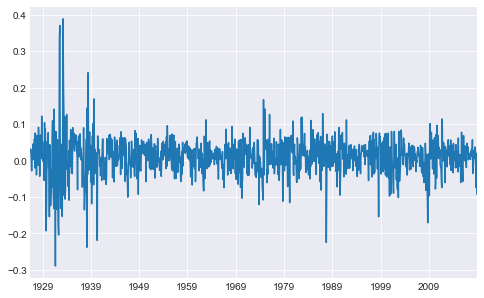

In [5]:
tot_mkt_rets = erk.get_total_market_index_returns()
tot_mkt_rets.plot(grid=True, figsize=(8,5))
plt.show()

The annualized volatility over the entire period is:

In [6]:
ann_vol_constant = erk.annualize_vol(tot_mkt_rets, periods_per_year=12)
ann_vol_constant

0.18360776591130698

However, let us using a rolling window and let us compute the timeseries of annualized volatilities:

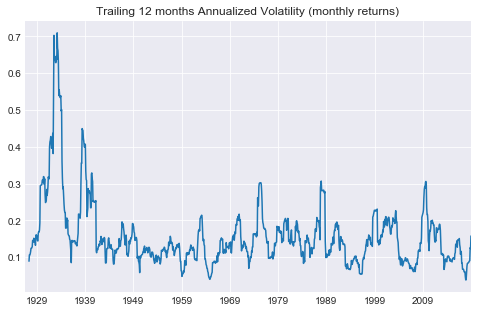

In [15]:
# pick yearly data (i.e., 12 monthly data)
window = 12
ann_vol_tv = tot_mkt_rets.rolling(window = 1*window).std() * np.sqrt(window)
ann_vol_tv.plot(grid=True, figsize=(8,5), title="Trailing 12 months Annualized Volatility (monthly returns)")
plt.show()

We see that the mean volatility of this timie-varying series is given by:

In [16]:
ann_vol_tv.mean()

0.15770732194601642

which is different from the "static" variance we have used over the entire period. 

#### Volatility cone 
Note that in the computation above, the volatility timeseries changes when windows changes. In particular, we can plot the so-called **volatility cone** which plot the minimum and the maximum of the volatility timeseries when the window changes.

Below the change the window by years:

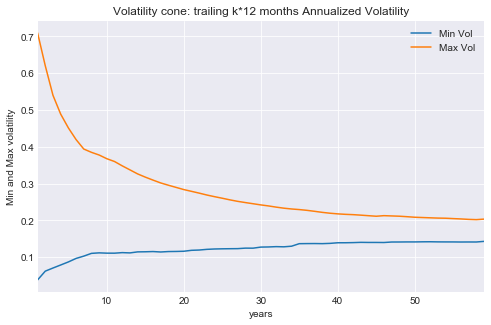

In [69]:
# pick yearly data (i.e., 12 monthly data)
window = 12
years  = np.arange(1,60,1)

mm_vol = []
for k in years:
    ann_vol_tv = tot_mkt_rets.rolling(window = k*window).std() * np.sqrt(window)
    mm_vol.append( [ann_vol_tv.min(), ann_vol_tv.max()] )

vol_cone = pd.DataFrame(mm_vol, index=years, columns=["Min Vol", "Max Vol"])

ax = vol_cone.plot(grid=True, figsize=(8,5), title="Volatility cone: trailing k*12 months Annualized Volatility")
ax.set_xlabel("years")
ax.set_ylabel("Min and Max volatility")
plt.show()

We can see that as soon as the window increase the cone shrinks, in particular the recorded maximum volatility decreases.

The assumption that the variance of a series of return may be uniform (constant) is known as **homoskedasticity**. When this is not the case (almost always) we talk about **heteroskedasticity**. 
Morevoer, the fact that the variance is not uniform and it is affected by previous variances 
is referred to as **autoregression** (in statistics we talk about **conditional** variance).

We have to compute the volatility in a way that takes into account variations over time. 

#### Exponentially Weigthed (Moving) Average (EWMA)

Let us define the squared error returns by $\epsilon_n^2 := (r_n - \mu)^2$, where $\mu:=\frac{1}{N}\sum_{i=1}^N r_n$ is the mean return over the entire timeseries.

When we compute the variance, by definition:
$$
\sigma^2_N = \frac{1}{N} \sum_{n=1}^N \epsilon_n^2 
= \frac{1}{N}\epsilon_1^2 + \dots + \frac{1}{N}\epsilon_N^2, 
$$
that is, we are doing a **weigthed average of the squared error returns** where the weigths are all the same and equal to $1/N$. That is, we can rewrite: 
$$
\sigma^2_N = \sum_{n=1}^N \alpha_n \epsilon^2_n
\quad\text{where}\quad 
\alpha_n = \frac{1}{N} \; \forall\; n 
\quad\text{s.t.}\quad 
\sum_{n=1}^N \alpha_n = 1.
$$
Notice that we strees the dependence of $\sigma^2_N$ on $N$ to say that this is the variance computed today, at time $N$. 

It is clear that this way of proceedings treats very old returns as important as more recent one.
This may not make sense because if the return distribution is not stationary we know that volatility will be changing over time and then oldest data points are not as informative as the most recent observations.

The new idea is then to **assign "more weight" to the most recent observations and "lower weights" to the oldest observations**. A natural way is to introduce an **exponentially weighted moving average 
(EWMA)** model where we assume that the weights assigned **decline exponentially as we move back in time**. 
We define the weigths as:
$$
\sigma^2_{N,EWA} = \sum_{n=1}^N \alpha_n \epsilon_n^2
\quad\text{where}\quad
\alpha_n = \frac{ \lambda^{N-n} }{\sum_{n=1}^N \lambda^{N-n} } \;\; \forall\; n, 
$$
where $\lambda^{T-n} \in (0,1]$ is the **decay (or smoothing) factor**. Here, 
the lowest the decay factor the fastest the decrease of the importance of oldest returns. 
Thus with a very low decay factor, only the very recent returns will significantly impact the volatility (note that these weights sum to $1$ and with $\lambda^{T-n}=1$ for all $n$ 
we recover the definition of volatility).

For example, **RiskMetrics** (a financial risk management company) tends to use a decay factor of $\lambda=0.94$.

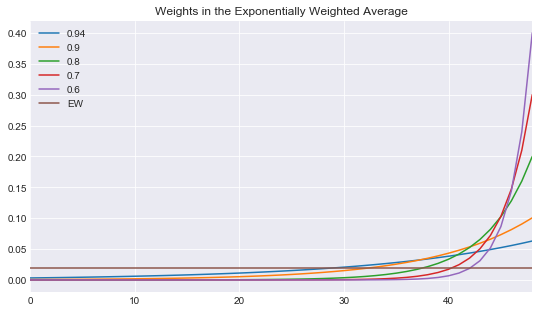

In [144]:
# Example:
T = 50
points = np.arange(1,T,1)
decay_factor = [0.94, 0.9, 0.8, 0.7, 0.6]

ww = []
for d in decay_factor:
    ww.append( [ d**(T-t) for t in points ] / np.sum( d**(T-points) ) )

weigths = pd.DataFrame(ww, index=decay_factor).T
weigths["EW"] = 1/T
weigths.plot(grid=True, figsize=(9,5), title="Weights in the Exponentially Weighted Average")
plt.show()

Let us see how volatilities changes using the EWA (using the **annualize_vol_ewa** method in the kit):

In [140]:
tot_mkt_rets = erk.get_total_market_index_returns()
ann_vol_constant = erk.annualize_vol(tot_mkt_rets, periods_per_year=12)

print("Standard volatility : {:.2f}%" .format(ann_vol_constant*100))
print("Exponentially Weigth:")

decays = [0.97, 0.95, 0.93, 0.85, 0.837]
for d in decays:
    ann_vol_ewa = erk.annualize_vol_ewa(tot_mkt_rets, decay=d, periods_per_year=12)
    print("         decay={:.3f}: {:.2f}%" .format(d, ann_vol_ewa*100))

Standard volatility : 18.36%
Exponentially Weigth:
         decay=0.970: 12.58%
         decay=0.950: 13.06%
         decay=0.930: 14.03%
         decay=0.850: 17.83%
         decay=0.837: 18.36%


Observe how the standard volatility corresponds to the EWA volatility with decay factorof 
about $\lambda=0.837$.

#### Auto-regressive Conditional Heteroscedasticity (ARCH) model 

The **autoregressive conditional heteroscedasticity (ARCH)** model is a variation around the same methodology of the exponential weigthed average idea in which the variance is supposed to be time-varying and dependent on some previous variances. 

In this model, the difference is that we use a kind of **long-term variance estimate** as an anchor point. 
Let us call by $V_L$ the very "long-term estimator for the variance" that can be given, **for example, by the volatility or the variance estimate over the last 50, 20 years**. 

We write ARCH($p$) to say that we use define current (today's) variance 
as a function of last previous $p$ squared error returns: 
$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega} 
+ \sum_{n=1}^p \alpha_{N-n} \epsilon_{N-n}^2
\quad \text{where} \quad
\gamma + \sum_{n=1}^p \alpha_n = 1.
$$
If $p=N$ then we use the entire timeseries of returns of $N$ points. 

If $p=1$, we use only the last previous squared error return:
$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega} 
+ \alpha_{N-1} \epsilon_{N-1}^2
\quad \text{where} \quad
\gamma + \alpha_{N-1} = 1.
$$


#### Generalized Auto-regressive Conditional Heteroscedasticity (GARCH) model 

The **Generalized Auto-regressive Conditional Heteroscedasticity (GARCH)** model is an improvement over the ARCH model that is going to have also a weighted average of the last, previous, estimate of variance.

We call GARCH($p,q$) the model:
$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega} 
+ \sum_{n=1}^p \alpha_{N-n} \epsilon_{N-n}^2
+ \sum_{m=1}^q \beta_{N-m} \sigma_{N-m}^2
\quad \text{where} \quad
\gamma + \sum_{n=1}^p \alpha_{N-n} + \sum_{m=1}^q \beta_{N-m} = 1,
$$

For $p=q=1$ we have the simplest GARCH(1,1) model:
$$
\sigma_{N}^2 = \gamma V_L + \alpha_{N-1} \epsilon_{N-1}^2 + \beta_{N-1} \sigma^2_{N-1}
\quad \text{where} \quad
\gamma + \alpha_{N-1} + \beta_{N-1} = 1,
$$

Note that when using a GARCH (or ARCH) model we are indeed increasing the number of parameters to estimate, as for each asset's volatility we have about $p+q$ parameters to estimate. 
If we are looking at a fairly large number of assets, and we are concerned that volatility is time-varying, there are parsimonious ways to use GARCH model known as **Factor GARCH**, 
in which instead of using $q$ past variances in the GARCH($p,q$) we instead use a $K$ variances (with $K<q$) computed with a $K$-factor model.

### Portfolio Index construction with different covariance estimator 

We've backtested CW and EW Portfolios and they each have unique positions in industrial implementations.

Cap-weighted portfolios are the overall average and hence the *de-facto* industry standard. 
They are very inexpensive to implement and feature very low turnover. 
In many ways, they are the default go-to implementation choice for many investors.

However, we've seen that they suffer from some disadvantages, so there is some room for improvement.

EW are the most obvious improvement because they are the only other technique we are going to look at (other than CW) that requires no estimation of either covariance or expected returns. We've already backtested those and we've seen how easy they are to build.

Now, we move on the construction of such portfolios using different covariance estimators.

In [5]:
nind = 49
ind_rets = erk.get_ind_file(filetype="rets", nind=nind, ew=True)["1974":]
ind_mcap = erk.get_ind_market_caps(nind=nind, weights=True)["1974":]

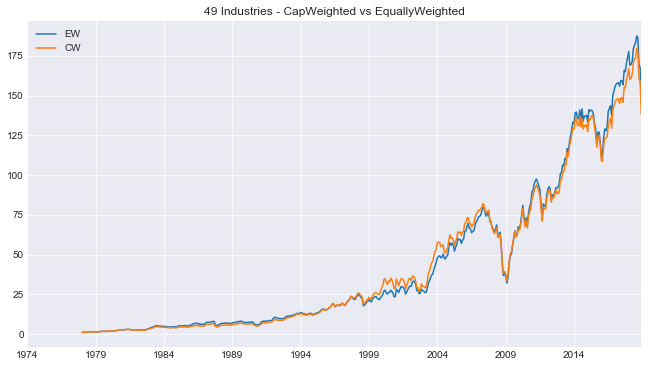

In [6]:
window  = 4*12 
ew_rets = erk.backtest_weight_scheme(ind_rets, window=window, weight_scheme=erk.weight_ew)
cw_rets = erk.backtest_weight_scheme(ind_rets, window=window, weight_scheme=erk.weight_cw, cap_ws=ind_mcap)

bt_rets   = pd.DataFrame({"EW": ew_rets, "CW": cw_rets})
bt_growth = (1 + bt_rets).cumprod()
bt_growth.plot(grid=True, figsize=(11,6), title="{} Industries - CapWeighted vs EquallyWeighted".format(nind))
plt.show()

In [7]:
erk.summary_stats( bt_rets.dropna() )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.129403,0.189212,0.511098,-0.609188,6.670753,0.124043,0.083067,-0.598060
CW,0.127760,0.187210,0.508023,-0.582342,5.799216,0.121187,0.082793,-0.592711


#### Building the Minimum Variance Portfolio

We have previously written the code (from the course 1) to build the minimum variance portfolio 
given the covariance, the **erk.minimize_volatility** method. We will use this method to build the minimum variance portfolio giving in input different covariance matrix estimator.

In [197]:
# minimum variance index portfolio using standard covariance matrix
minvar_rets = erk.backtest_weight_scheme(ind_rets, window=window, weight_scheme=erk.weight_minvar, cov_estimator=erk.sample_cov, periods_per_year=12)

# minimum variance index portfolio using constant (constant correlation) covariance matrix
minvar_cc_rets = erk.backtest_weight_scheme(ind_rets, window=window, weight_scheme=erk.weight_minvar, cov_estimator=erk.cc_cov, periods_per_year=12)

# minimum variance index portfolio using shrinkage covariance matrix
minvar_shrink_rets = erk.backtest_weight_scheme(ind_rets, window=window, weight_scheme=erk.weight_minvar, 
                                                cov_estimator=erk.shrinkage_cov, periods_per_year=12)

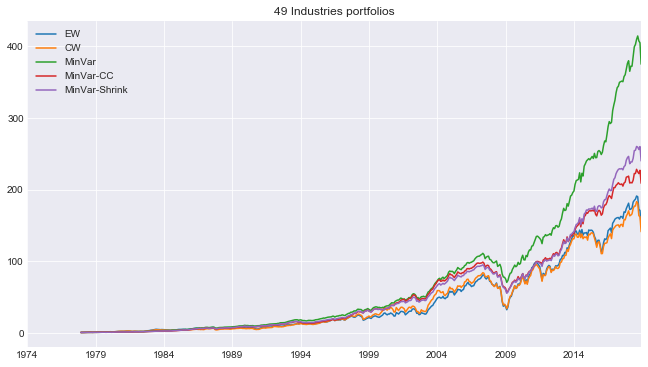

In [307]:
bt_rets   = pd.DataFrame({"EW": ew_rets, 
                          "CW": cw_rets,
                          "MinVar": minvar_rets, 
                          "MinVar-CC": minvar_cc_rets,
                          "MinVar-Shrink": minvar_shrink_rets})
bt_growth = (1 + bt_rets).cumprod()
bt_growth.plot(grid=True, figsize=(11,6), title="{} Industries portfolios".format(nind))
plt.show()

In [308]:
erk.summary_stats( bt_rets.dropna() )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.129671,0.189024,0.512985,-0.610690,6.684435,0.124043,0.082963,-0.598060
CW,0.128113,0.187105,0.510146,-0.586055,5.784146,0.121312,0.082784,-0.593851
MinVar,0.155201,0.100047,1.217987,-0.562825,4.941997,0.059209,0.038259,-0.364208
MinVar-CC,0.138878,0.105344,1.005890,-0.544836,4.605069,0.064945,0.042163,-0.429581
MinVar-Shrink,0.142734,0.102157,1.074023,-0.547661,4.722257,0.062546,0.040239,-0.416114


In [202]:
#maxsrp_rets = erk.backtest_weight_scheme(ind_rets, window=window, weight_scheme=erk.weight_maxsharpe, cov_estimator=erk.sample_cov, 
                                         #risk_free_rate=0.03, periods_per_year=12)

Look at the weights:

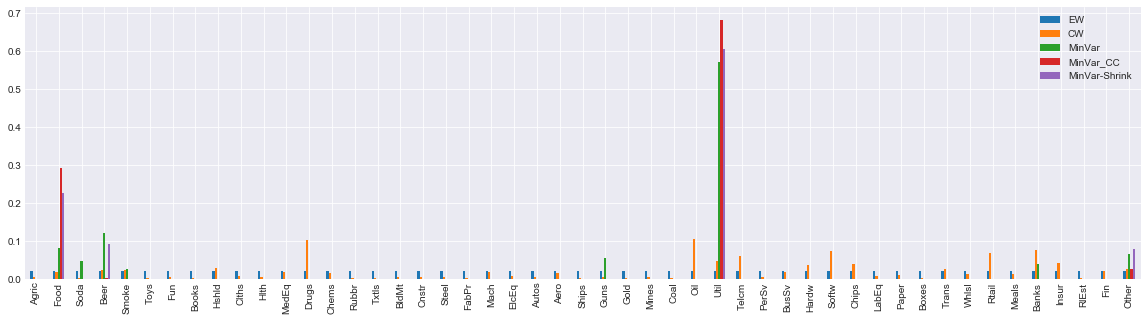

In [311]:
ww = pd.DataFrame({    
    "EW": erk.weight_ew(ind_rets["2009":]),
    "CW": erk.weight_cw(ind_rets["2009":], cap_ws=ind_mcap),
    "MinVar": weight_minvar(ind_rets["2009":], cov_estimator=sample_cov),
    "MinVar_CC": weight_minvar(ind_rets["2009":], cov_estimator=cc_cov),
    "MinVar-Shrink": weight_minvar(ind_rets["2009":], cov_estimator=shrinkage_cov),
    #"MaxSrp": weight_maxsharpe(ind_rets["2008":], cov_estimator=sample_cov)
})
ww.plot.bar(grid=True, figsize=(20,5))
plt.show()

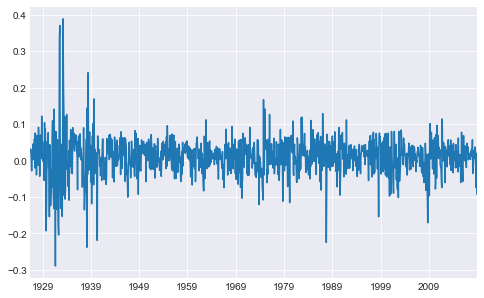

In [6]:
tot_mkt_rets = erk.get_total_market_index_returns()
tot_mkt_rets.plot(grid=True, figsize=(8,5))
plt.show()

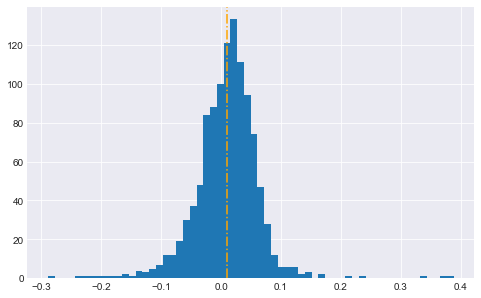

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
tot_mkt_rets.hist(ax=ax, bins=60)
ax.axvline(x=tot_mkt_rets.mean(),linestyle="-.",color="orange")

In [19]:
alpha = np.array([0.90, 0.95, 0.99])
level = 1 - alpha

# In the percentile method, we multiply by 100 because it wants an input between 0 and 100
VaRs = -np.percentile(tot_mkt_rets, level*100)
VaRs

array([0.04958565, 0.07434804, 0.13540544])

In [61]:
tot_mkt_rets.rolling(window=12).std().head(20) #.std()

1926-07         NaN
1926-08         NaN
1926-09         NaN
1926-10         NaN
1926-11         NaN
1926-12         NaN
1927-01         NaN
1927-02         NaN
1927-03         NaN
1927-04         NaN
1927-05         NaN
1927-06    0.025635
1927-07    0.030649
1927-08    0.030533
1927-09    0.031394
1927-10    0.033156
1927-11    0.035793
1927-12    0.035779
1928-01    0.036197
1928-02    0.037060
Freq: M, dtype: float64

In [39]:
tot_mkt_rets[2:14].std()

0.030533127751110813

In [115]:
alpha = 0.95
level = 1 - alpha

N = tot_mkt_rets.shape[0]
roll_window  = 12*3
windows = [ [start, start + roll_window] for start in range(0,N-window) ]
nans = np.repeat(np.nan,window).tolist()
histvars = [ erk.var_historic(tot_mkt_rets[w[0]:w[1]], level) for w in windows ]
histvars = pd.Series(nans + histvars, index=tot_mkt_rets.index)

histES = [ erk.cvar_historic(tot_mkt_rets[w[0]:w[1]], level) for w in windows ]
histES = pd.Series(nans + histES, index=tot_mkt_rets.index)


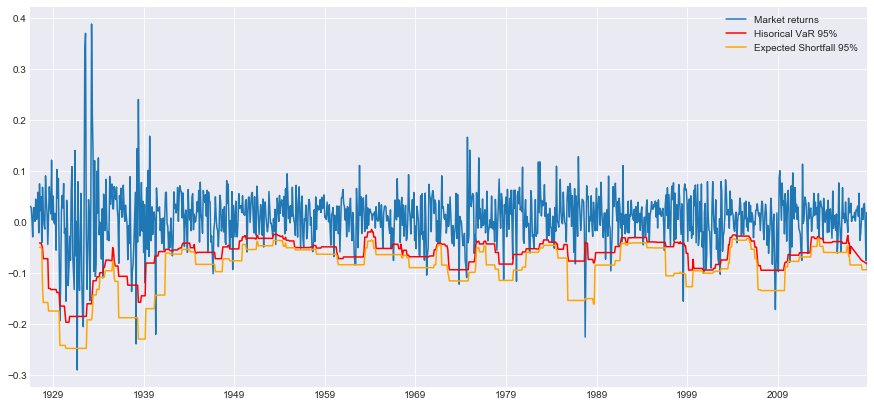

In [143]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
tot_mkt_rets.plot(ax=ax, grid=True, label="Market returns")

#histvars.plot(ax=ax, grid=True, color="red",  )
(-histvars).plot(ax=ax, grid=True, color="red", label="Hisorical VaR {:.0f}%".format(alpha*100))

#histES.plot(ax=ax, grid=True, color="orange")
(-histES).plot(ax=ax, grid=True, color="orange", label="Expected Shortfall {:.0f}%".format(alpha*100) )

plt.legend()
plt.show()

In [139]:
df = pd.concat([tot_mkt_rets, -histvars, -histES], axis=1).dropna()
df.columns = ["rets", "vars", "ES"]
df.head()

,rets,vars,ES
1927-07,0.075291,-0.040512,-0.048987
1927-08,0.022735,-0.040512,-0.048987
1927-09,0.049941,-0.040512,-0.048987
1927-10,-0.039566,-0.044878,-0.052045
1927-11,0.068690,-0.050756,-0.123761


In [140]:
df[ df["rets"] < df["vars"] ].shape[0],  df[ df["rets"] < df["ES"] ].shape[0]

(54, 31)

In [141]:
histvars.shape[0] * (1 - alpha)

55.50000000000005